# Destabilize The Page Ranks - Identifying Vulnerable Graphs


## Imports

In [3]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Draw the graph from the adjacency matrix

In [4]:
def draw_graph(adj_matrix):
    G = nx.DiGraph()
    G.add_nodes_from(range(len(adj_matrix)))

    for i in range(len(adj_matrix)):
        for j in range(len(adj_matrix[i])):
            if adj_matrix[i][j] == 1:
                G.add_edge(i, j) 

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightpink', node_size=500, font_weight='bold', arrows=True)
    plt.show()

## Ranking algorithms

In [5]:
def in_degree_algorithm(adj_matrix):
    num_nodes = len(adj_matrix)
    indegree = [0] * num_nodes  

    # Calculate indegree for each node
    for i in range(num_nodes):
        for j in range(num_nodes):
            indegree[i] += adj_matrix[j][i]

    # Create a list of tuples (node index, in-degree) and sort by in-degree in descending order
    ranked_pages = [(i, indegree[i]) for i in range(num_nodes)]
    ranked_pages.sort(key=lambda x: x[1], reverse=True)
    
    rankings = [0] * num_nodes
    for i, (node_idx, _) in enumerate(ranked_pages):
        rankings[node_idx] = i + 1  # Assign the ranking to the node
    
    return rankings

In [6]:
def page_rank_algorithm(adjacency_matrix, beta=0.85, k=100, epsilon=1e-8):
    n = len(adjacency_matrix)
    page_rank = np.ones(n) / n
    
    for _ in range(k):
        new_page_rank = np.zeros(n)
        teleportation_factor = (1 - beta) / n
        
        for i in range(n):
            outgoing_links = np.where(adjacency_matrix[i] != 0)[0]
            num_outgoing = len(outgoing_links)
            
            if num_outgoing == 0:
                # Handle spider traps by redistributing probability evenly 
                for j in range(n):
                    new_page_rank[j] += teleportation_factor * page_rank[i]
            else:
                # Distribute PageRank considering outgoing links and beta
                for link in outgoing_links:
                    new_page_rank[link] += beta * (page_rank[i] / num_outgoing)
            new_page_rank += teleportation_factor
        
        if np.sum(np.abs(new_page_rank - page_rank)) < epsilon:
            break
        
        page_rank = new_page_rank  
    
    # Sort the page ranks and return ordinal rank
    ordinal_ranks = np.argsort(-page_rank)
    ordinal_page_ranks = np.empty(n, dtype=int)
    for i, idx in enumerate(ordinal_ranks):
        ordinal_page_ranks[idx] = i + 1
    
    return ordinal_page_ranks

In [7]:
def get_ordinal_ranks(scores):
    ordinal_ranks = np.argsort(-scores)
    ordinal_page_ranks = np.empty(len(scores), dtype=int)
    for i, idx in enumerate(ordinal_ranks):
        ordinal_page_ranks[idx] = i + 1
    return ordinal_page_ranks

def hits_algorithm(adjacency_matrix, max_iterations=100, tolerance=1.0e-6):
    n = len(adjacency_matrix)
    authority = np.ones(n)
    hub = np.ones(n)
    
    for _ in range(max_iterations):
        prev_authority = authority.copy()
        prev_hub = hub.copy()
        
        # Update authority scores based on hub scores
        authority = np.dot(adjacency_matrix.T, hub)
        
        # Update hub scores based on authority scores
        hub = np.dot(adjacency_matrix, authority)
        
        # Normalize scores
        authority /= np.linalg.norm(authority)
        hub /= np.linalg.norm(hub)
        
        # Check if done
        authority_change = np.linalg.norm(authority - prev_authority)
        hub_change = np.linalg.norm(hub - prev_hub)
        if authority_change < tolerance and hub_change < tolerance:
            break
    
    authority = get_ordinal_ranks(authority)
    hub = get_ordinal_ranks(hub)
    return authority

## Modify the adjacency matrix by inverting k links

In [8]:
def modify_matrix_by_link_distance(adjacency_matrix, k):
    modified_matrix = np.copy(adjacency_matrix)

    # Generate all possible indices in the matrix
    all_indices = [(i, j) for i in range(modified_matrix.shape[0]) for j in range(modified_matrix.shape[1])]

    # Randomly select k unique indices
    selected_indices = random.sample(all_indices, k)

    # Invert the values at the selected indices
    for i, j in selected_indices:
        modified_matrix[i, j] = 1 - modified_matrix[i, j]

    return modified_matrix


## Calculate euclidean distance between 2 rank vectors

In [9]:
# Distance between 2 vectors
def vector_distance(vector1, vector2):
    array1 = np.array(vector1)
    array2 = np.array(vector2)

    # Calculate the Euclidean distance
    distance = np.linalg.norm(array1 - array2)

    return distance

## Functions to create different types of graphs

In [10]:
# Random Directed Graph:
def create_random_graph(n,p):
    G = nx.erdos_renyi_graph(n, p, directed=True)
    return G

# Complete Directed Graph:
def create_complete_graph(n):
    G = nx.complete_graph(n, create_using=nx.DiGraph)
    return G

# Fully Disconnected Directed Graph:
def create_disconnected_graph(n):
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    return G

"""
Directed Scale-Free graph using the Barabási–Albert model:
n - Number of nodes
m - Number of edges to attach from a new node to existing nodes
"""
def create_scale_free_graph(n, m):
    G = nx.DiGraph()

    # Start with a complete graph of m+1 nodes
    G.add_nodes_from(range(m + 1))
    G.add_edges_from([(i, j) for i in range(m + 1) for j in range(m + 1) if i != j])

    # Preferential attachment
    for i in range(m + 1, n):
        targets = list(G.nodes)
        for _ in range(m):
            new_target = random.choice(targets)
            G.add_edge(i, new_target)

    return G

"""
Directed Small-World graph using the Watts-Strogatz model:
n - Number of nodes
k - Each node is connected to k nearest neighbors in ring topology
p - Probability of rewiring each edge
"""
def create_small_world_graph(n,k,p):
    G = nx.DiGraph()
    
    # Create a directed ring lattice
    for i in range(n):
        targets = list(range(i+1, i+1+k//2)) + list(range(i-k//2, i))
        targets = [t % n for t in targets]  # Ensure indices wrap around
        G.add_edges_from((i, t) for t in targets if i != t)  # Avoid self-edges
    
    # Rewire edges with probability p
    for edge in list(G.edges()):
        if np.random.rand() < p:
            G.remove_edge(*edge)
            new_target = np.random.choice(n)
            while new_target == edge[0]:  # Avoid self-edges
                new_target = np.random.choice(n)
            G.add_edge(edge[0], new_target)

    return G

# The Tree graph:
def create_tree_graph(n):
    G = nx.random_tree(n, seed=42, create_using=nx.DiGraph)
    return G

# The Cycle graph:
def create_cycle_graph(n):
    G = nx.cycle_graph(n, create_using=nx.DiGraph)
    return G

# The arrow graph:
def create_arrow_graph(n):
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    for i in range(n - 1):
        G.add_edge(i, i + 1)
    return G

# The inward-star graph:
def create_inward_star_graph(n):
    G = nx.DiGraph()

    # Add central node
    G.add_node(0)

    for i in range(1, n):
        G.add_node(i)
        G.add_edge(i, 0)
    return G

# The directed nxn grid graph:
def create_grid_graph(n):
    G = nx.DiGraph()
    
    # Add nodes
    for i in range(1, n*n + 1):
        G.add_node(i)
    
    for x in G.nodes:
        if x % n != 0 :
            G.add_edge(x, x+1)
            if x <= n*n - n:
                G.add_edge(x, x+n)
        else:
            if x <= n*n - n:
                G.add_edge(x, x+n)
    
    return G


## Function to calculate the Euclidean distances between the original and the modified ranking vector for a specific ranking algorithm and multiple k changes

In [11]:
def calculate_distance(original_graph, k_values, algorithm):
    distances = []
    adjacency_original = nx.adjacency_matrix(original_graph).todense()
    ranking_original = algorithm(adjacency_original)
    for k in k_values:
        adjacency_modified = modify_matrix_by_link_distance(adjacency_original, k)
        ranking_modified = algorithm(adjacency_modified)
        euclidean_distance = vector_distance(ranking_original, ranking_modified)
        distances.append(euclidean_distance)
                         
    return distances

## Create a list with different types of graphs 

In [12]:
n = 10 # Number of nodes
k_values = list(range(10))  # Number of changes to make to the graph

graphs = []

random_graph = create_random_graph(n, 0.3)
random_graph.name = "Random Graph"
graphs.append(random_graph)

complete_graph = create_complete_graph(n)
complete_graph.name = "Complete Graph"
graphs.append(complete_graph)

disconnected_graph = create_disconnected_graph(n)
disconnected_graph.name = "Disconnected Graph"
graphs.append(disconnected_graph)

scale_free_graph = create_scale_free_graph(n, 3)
scale_free_graph.name = "Scale Free Graph"
graphs.append(scale_free_graph)

small_world_graph = create_small_world_graph(n, 4, 0.2)
small_world_graph.name = "Small World Graph"
graphs.append(small_world_graph)

tree_graph = create_tree_graph(n)
tree_graph.name = "Tree Graph"
graphs.append(tree_graph)

cycle_graph = create_cycle_graph(n)
cycle_graph.name = "Cycle Graph"
graphs.append(cycle_graph)

arrow_graph = create_arrow_graph(n)
arrow_graph.name = "Arrow Graph"
graphs.append(arrow_graph)

inward_star_graph = create_inward_star_graph(n)
inward_star_graph.name = "Inward Star Graph"
graphs.append(inward_star_graph)

grid_graph = create_grid_graph(n)
grid_graph.name = "Grid Graph"
graphs.append(grid_graph)

## Plot the Euclidean distances for each graph and each ranking algorithm

We make 3 plots for each ranking algorithm.
Each plot contains the Euclidean distances for each type of graph and different k changes.
From the plots, we can see how the Euclidean distances change for different types of graphs as the number of changes (k) increases.
So, if the graphs have big variations from one k to another, we can say that the these graphs are more sensitive to changes, so they're more vulnerable.

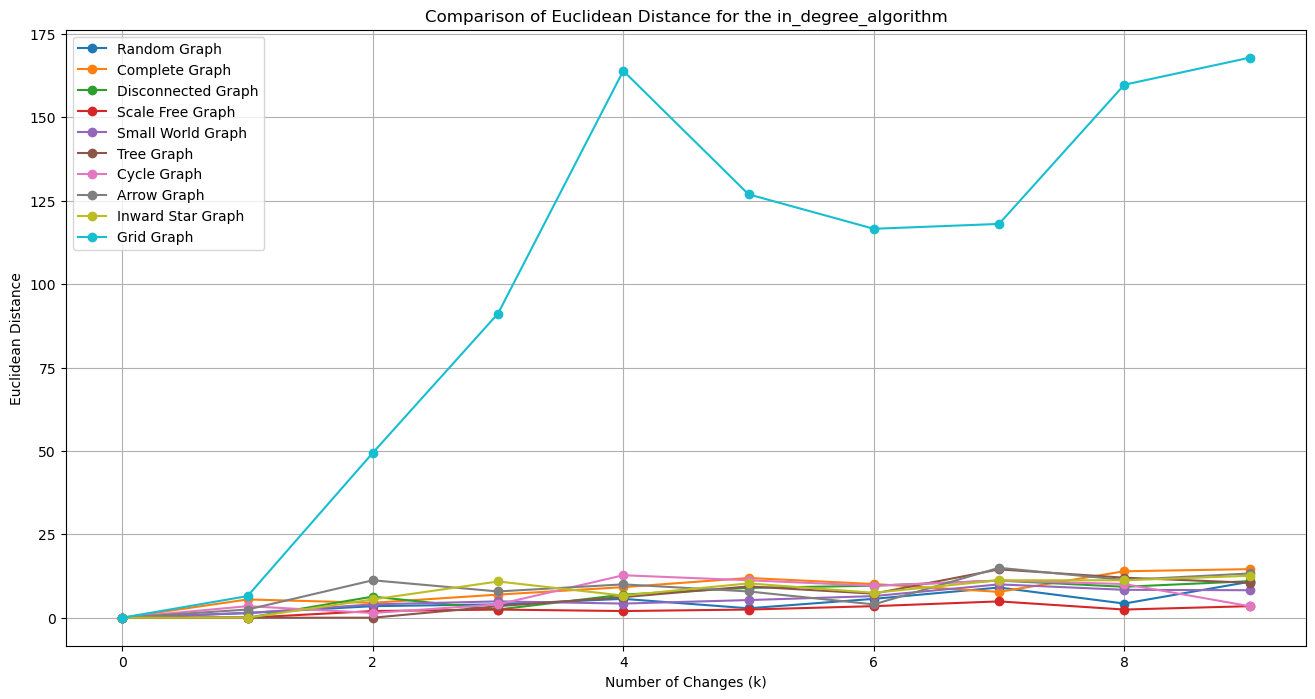

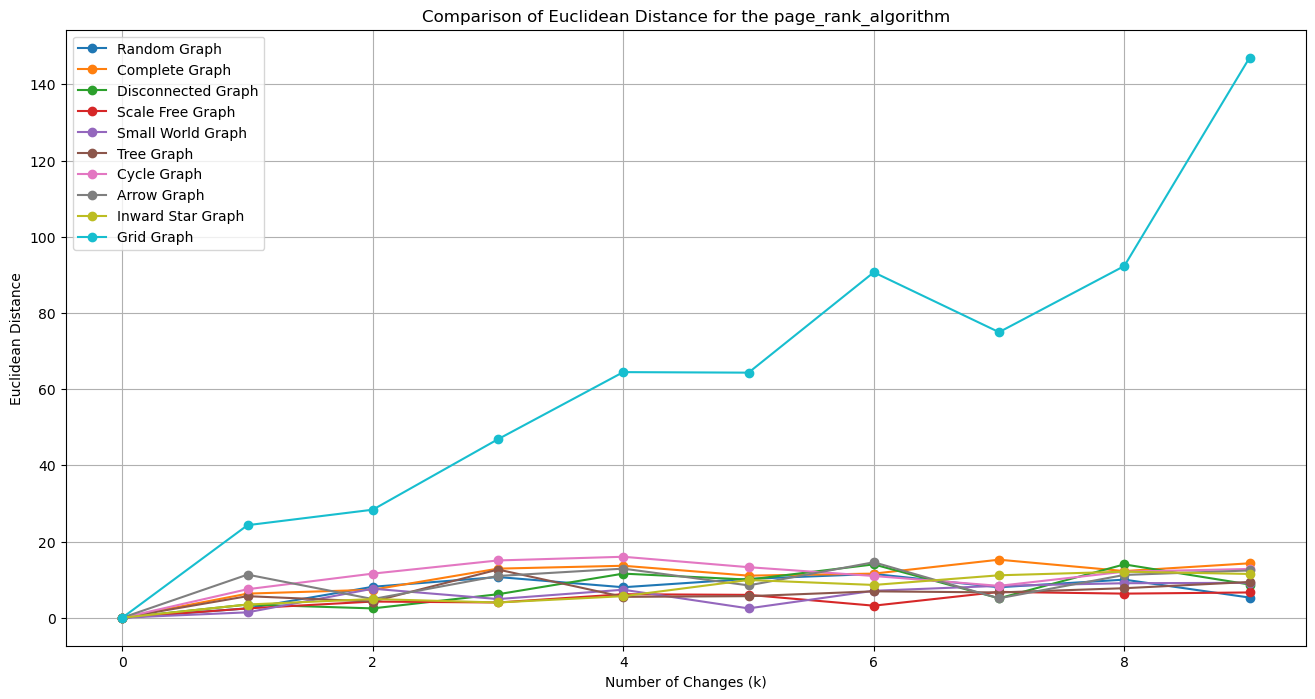

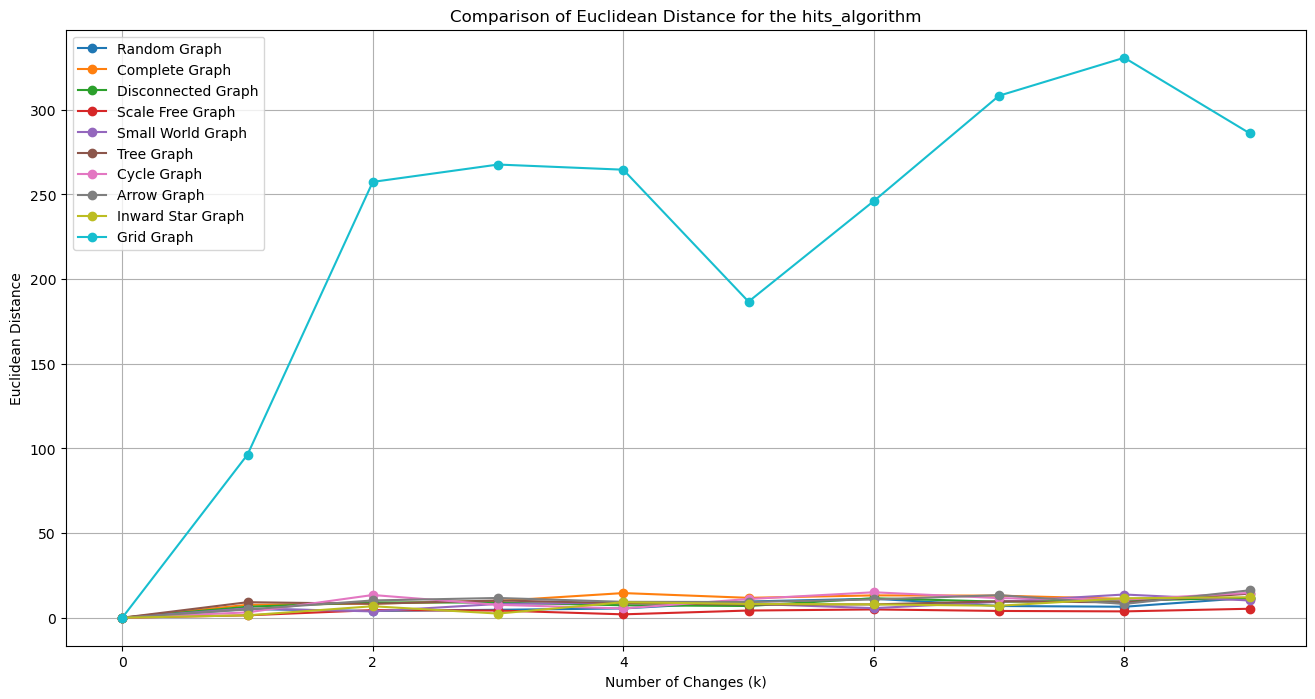

In [85]:
algorithms = [in_degree_algorithm, page_rank_algorithm, hits_algorithm]
for algorithm in algorithms:
    plt.figure(figsize=(16, 8))
    for graph in graphs:
        euclidean_distances = calculate_distance(graph, k_values, algorithm)
        plt.plot(k_values, euclidean_distances, marker='o', label=graph.name)
    plt.xlabel('Number of Changes (k)')
    plt.ylabel('Euclidean Distance')
    plt.title(f'Comparison of Euclidean Distance for the {algorithm.__name__}')
    plt.legend()
    plt.grid(True)
    plt.show()
    

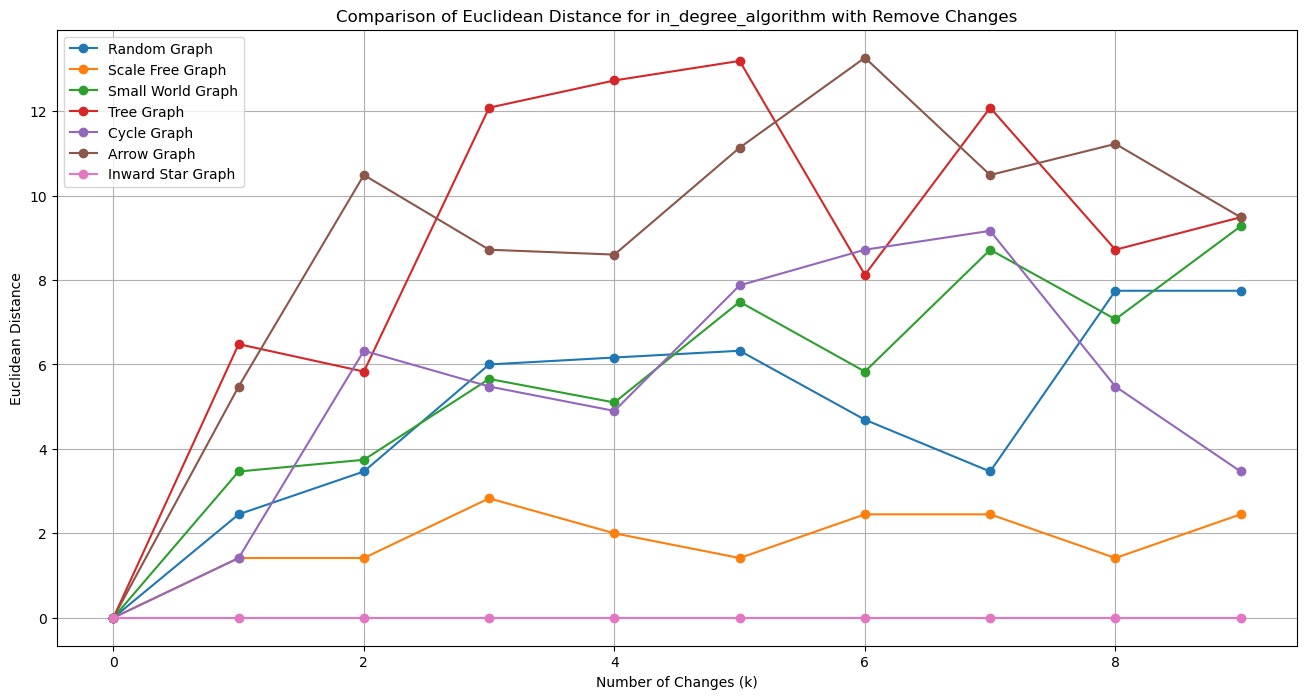

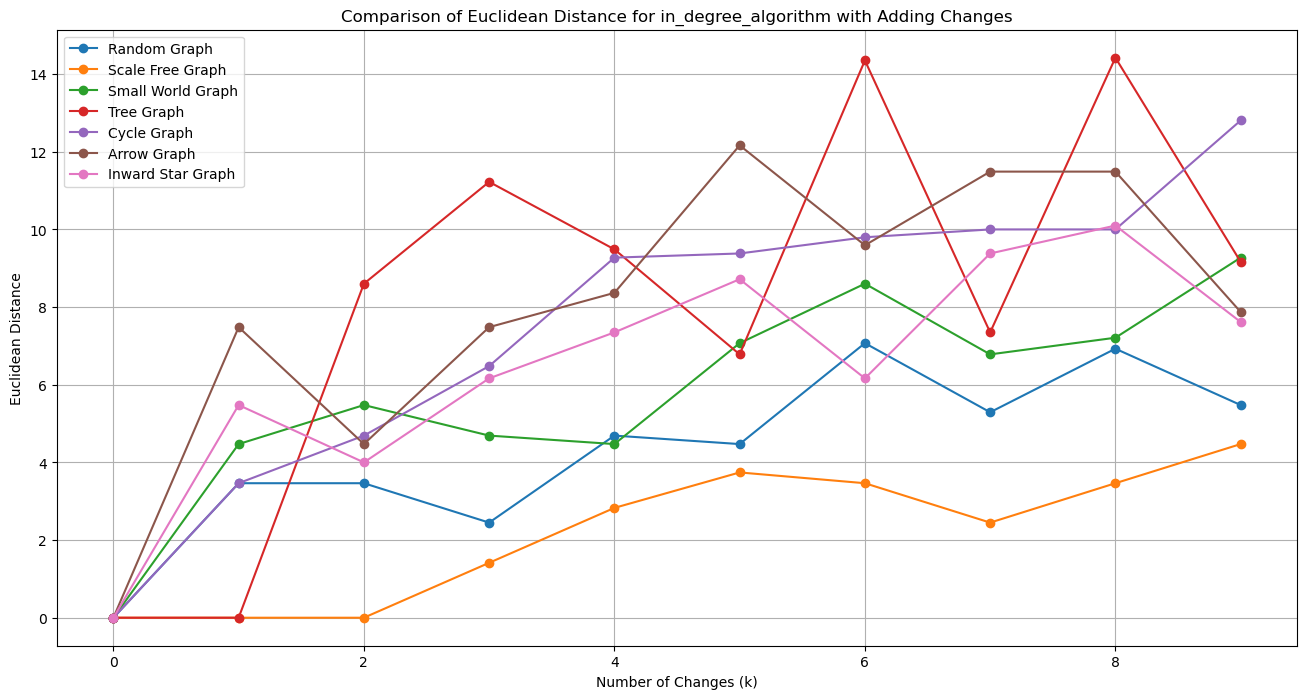

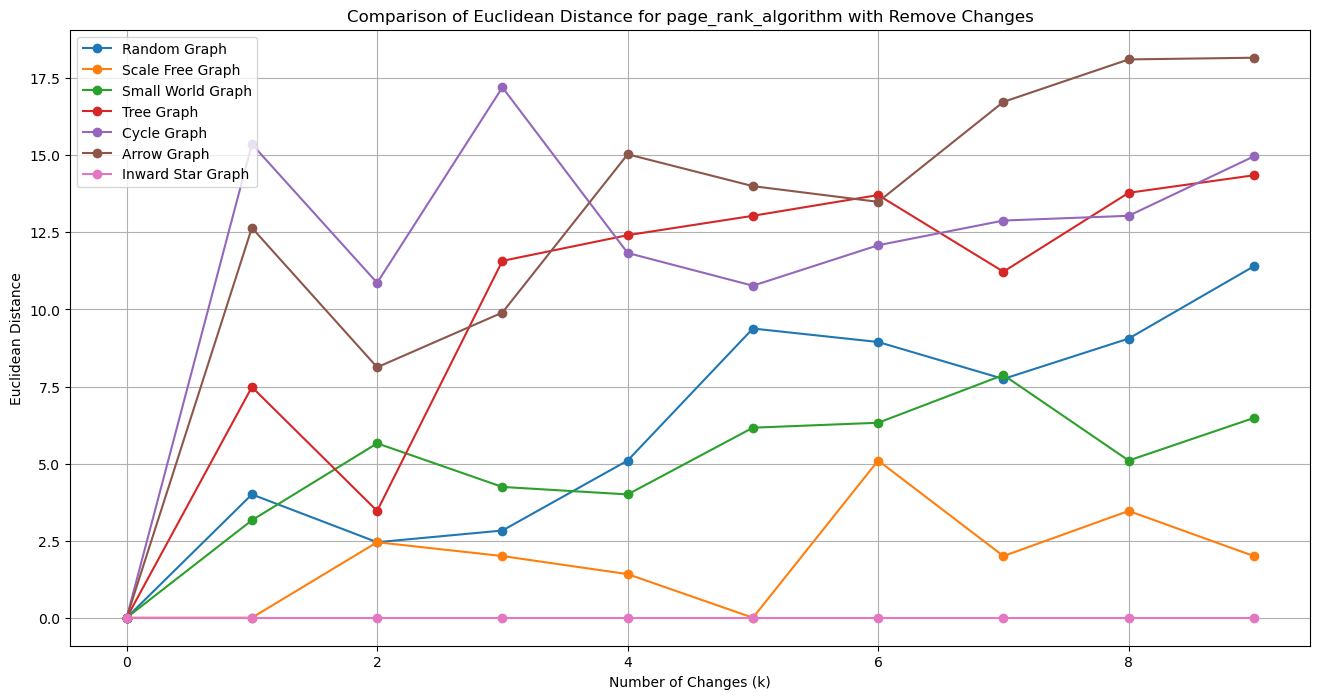

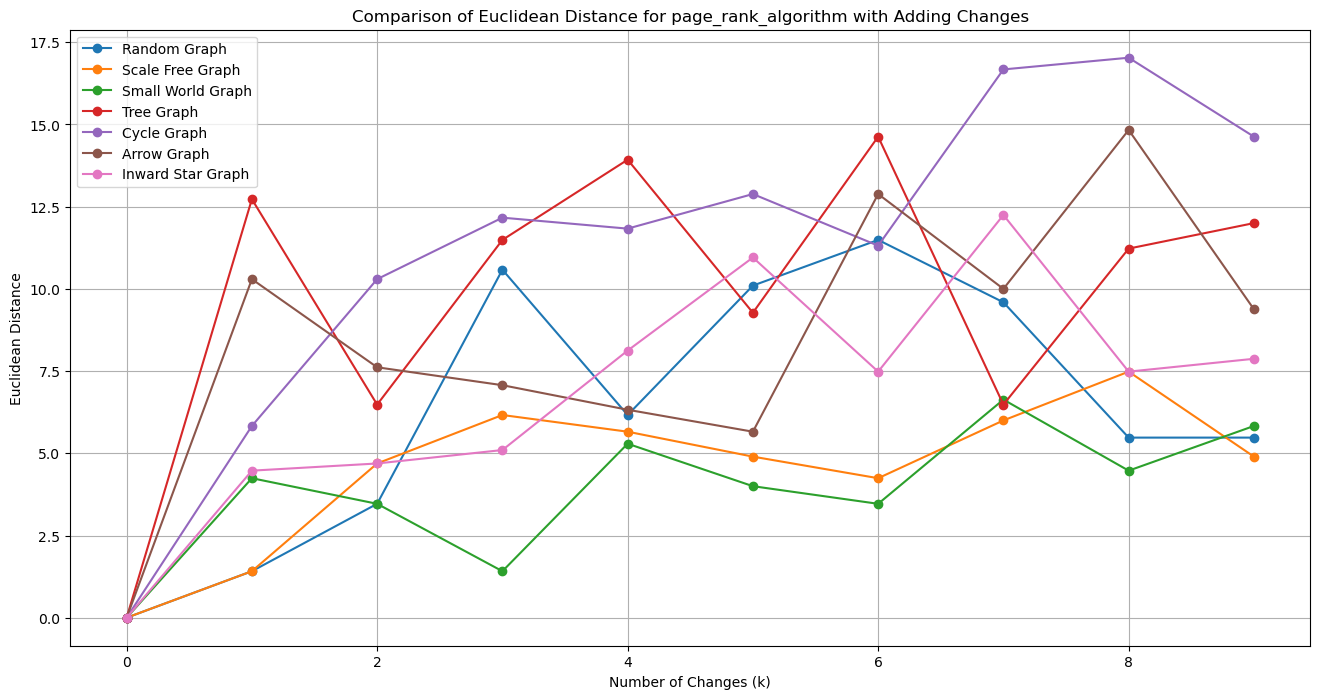

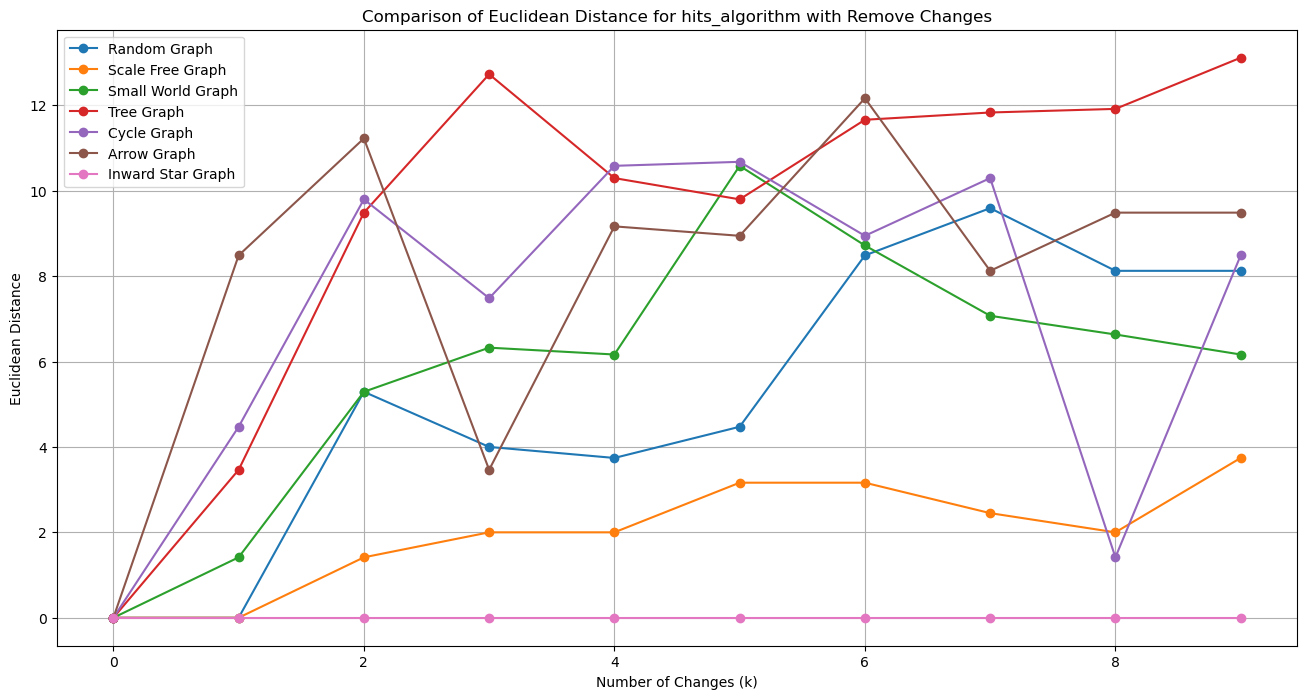

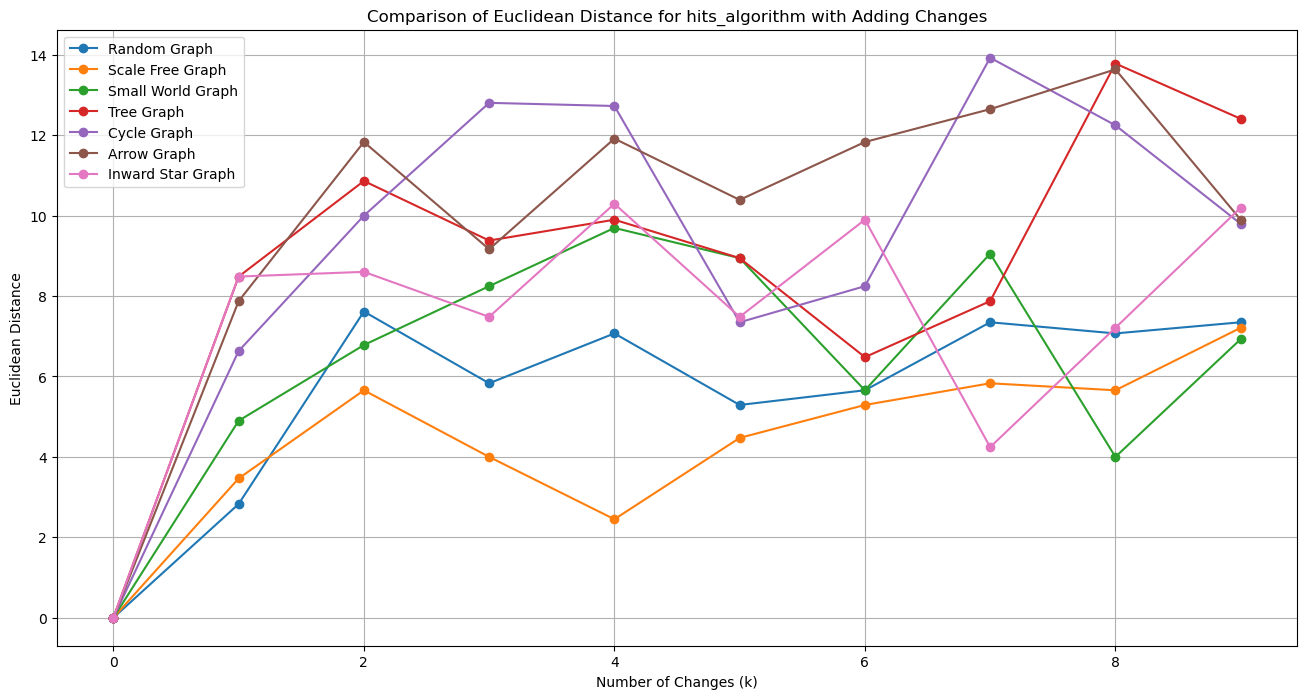

In [86]:
def only_remove_changes(G, k):
    G1 = G.copy()
    nr_edges = G1.number_of_edges()
    if k > nr_edges:
        raise ValueError("k must be less than the number of edges")
    else:
        edges = list(G1.edges())
        for _ in range(k):
            edge_to_remove = random.choice(edges)
            edges.remove(edge_to_remove)
            G1.remove_edge(*edge_to_remove)
    
    return G1

def only_add_changes(G, k):
    G1 = G.copy()
    nodes = G1.number_of_nodes()
    all_possible_edges = [(v, j) for v in range(nodes) for j in range(nodes) if v != j]
    all_edges = list(G1.edges())
    all_possible_new_edges = list(set(all_possible_edges) - set(all_edges))
    if k > len(all_possible_new_edges):
        raise ValueError("k must be less than the number of possible new edges")
    else:
        for _ in range(k):
            edge_to_add = random.choice(all_possible_new_edges)
            G1.add_edge(*edge_to_add)
            all_possible_new_edges.remove(edge_to_add)
    
    return G1

def calculate_distance1(original_graph, k_values, algorithm, only_changes):
    distances = []
    adjacency_original = nx.adjacency_matrix(original_graph).todense()
    ranking_original = algorithm(adjacency_original)
    for k in k_values:
        modified_graph = only_changes(original_graph,k)
        adjacency_modified = nx.adjacency_matrix(modified_graph).todense()
        ranking_modified = algorithm(adjacency_modified)
        euclidean_distance = vector_distance(ranking_original, ranking_modified)
        distances.append(euclidean_distance)
                         
    return distances

graphs.remove(complete_graph) # Can only remove edges in general
graphs.remove(disconnected_graph) # Can only add edges in general
graphs.remove(grid_graph) # Too much difference, so we ignore it 

# Create plots for each algorithm
for algorithm in algorithms:
    # Plot for remove changes
    plt.figure(figsize=(16, 8))
    for graph in graphs:
        euclidean_distances = calculate_distance1(graph, k_values, algorithm, only_remove_changes)
        plt.plot(k_values, euclidean_distances, marker='o', label=f'{graph.name}')
    plt.xlabel('Number of Changes (k)')
    plt.ylabel('Euclidean Distance')
    plt.title(f'Comparison of Euclidean Distance for {algorithm.__name__} with Remove Changes')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # PLot for add changes
    plt.figure(figsize=(16, 8))
    for graph in graphs:
        euclidean_distances = calculate_distance1(graph, k_values, algorithm, only_add_changes)
        plt.plot(k_values, euclidean_distances, marker='o', label=f'{graph.name}')
    plt.xlabel('Number of Changes (k)')
    plt.ylabel('Euclidean Distance')
    plt.title(f'Comparison of Euclidean Distance for {algorithm.__name__} with Adding Changes')
    plt.legend()
    plt.grid(True)
    plt.show()
    